# Example of using the feature extraction pipline in python

In [2]:
from __future__ import print_function
import sys
import SimpleITK as sitk
import dicom, os, copy, glob
from dicom.tag import Tag
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import polygon
from multiprocessing import cpu_count, Pool
from numba import jit, cuda
import copy
from copy import deepcopy
import re
import pandas as pd
import numba
import radiomics
import collections
from radiomics import featureextractor 
from radiomics import firstorder, getTestCase, glcm, glrlm, glszm, imageoperations, shape, generalinfo
from radiomics import _cmatrices as cMatrices
from radiomics import _cshape as cShape
from skimage.draw import polygon
import dicom
from dicom_contour.contour import *
from skimage.draw import polygon
from pydicom import dcmread
from __future__ import print_function
import six

# Functions to read RT structure file and generate image mask

In [9]:
def read_structure(structure):
    contours = []
    for i in range(len(structure.ROIContourSequence)):
        contour = {}
        contour['color'] = structure.ROIContourSequence[i].ROIDisplayColor
        contour['number'] = structure.ROIContourSequence[i].ReferencedROINumber
        contour['name'] = structure.StructureSetROISequence[i].ROIName
        assert contour['number'] == structure.StructureSetROISequence[i].ROINumber
        try:
            contour['contours'] = [s.ContourData for s in structure.ROIContourSequence[i].ContourSequence]
        except:
            pass
        contours.append(contour)
    return contours

def get_mask(contours, slices, image):
    z = [s.ImagePositionPatient[2] for s in slices]
    pos_r = slices[0].ImagePositionPatient[1]
    spacing_r = slices[0].PixelSpacing[1]
    pos_c = slices[0].ImagePositionPatient[0]
    spacing_c = slices[0].PixelSpacing[0]
    label = np.zeros_like(image, dtype=np.uint8)
    
    for c in contours["contours"]:
        nodes = np.array(c).reshape((-1, 3))
        assert np.amax(np.abs(np.diff(nodes[:, 2]))) == 0
        z_index = z.index(nodes[0, 2])
        r = (nodes[:, 1] - pos_r) / spacing_r
        c = (nodes[:, 0] - pos_c) / spacing_c
        rr, cc = polygon(abs(r), abs(c))
        label[z_index, rr, cc] = 1
        
    return label

def display_slices(image, mask, rows=2, cols=3, skip=1):
    """
    Displays a series of slices in z-direction that contains the segmented regions of interest.
    Ensures all contours are displayed in consistent and different colors.
        Parameters:
            image (array-like): Numpy array of image.
            mask (array-like): Numpy array of mask.
            skip (int): Only print every nth slice, i.e. if 3 only print every 3rd slice, default 1.
        Returns:
            None (series of in-line plots).
    """

    slice_locations = np.unique(np.where(mask != 0)[0]) # get indexes for where there is a contour present 
    slice_start = slice_locations[0] # first slice of contour 
    slice_end = slice_locations[len(slice_locations)-1] # last slice of contour
    
    fig,ax = plt.subplots(rows,cols,figsize=[18,12])
    for i in range(0,rows):
        for j in range(0,cols):
            img_arr = image[slice_start:slice_end+1][skip*i*j]
            contour_arr = mask[slice_start:slice_end+1][skip*i*j]

            masked_contour_arr = np.ma.masked_where(contour_arr == 0, contour_arr)
            ax[i,j].imshow(img_arr, cmap='gray', interpolation='none')
            ax[i,j].imshow(masked_contour_arr, cmap='cool', interpolation='none', alpha=0.2, vmin = 1, vmax = np.amax(mask)) # vmax is set as total number of contours so same colors can be displayed for each slice

    plt.show()

# Get the test case

In [4]:
filepath="C:/Users/ML/Test/Data"
ptdir = [os.path.join(filepath, name)
                   for name in os.listdir(filepath)
                   if os.path.isdir(os.path.join(filepath, name))]
subdir = ptdir[0]+'/DICOM'
print ([0,subdir])

[0, 'C:/Users/ML/Test/Data\\test001/DICOM']


# Read and load CT images

In [5]:
print("Reading Dicom directory:", subdir)
series_IDs = sitk.ImageSeriesReader.GetGDCMSeriesIDs(subdir)
series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(subdir, series_IDs[0])
series_reader = sitk.ImageSeriesReader()
series_reader.SetFileNames(series_file_names)
series_reader.LoadPrivateTagsOn()
image3D = series_reader.Execute()
dimension=image3D.GetDimension()
size = image3D.GetSize()
origin = image3D.GetOrigin()
spacing = image3D.GetSpacing()
direction = image3D.GetDirection()

print("Image dimension:", dimension)
print("Image origin:", origin)
print("Image size:", size)
print("Image spacing:", spacing)
print("Image direction:", direction)

Reading Dicom directory: C:/Users/ML/Test/Data\test001/DICOM
Image dimension: 3
Image origin: (-185.609375, -380.609375, -562.2)
Image size: (512, 512, 625)
Image spacing: (0.78125, 0.78125, 0.8)
Image direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


# This step is to remove air component by excluding CT values below - 200

In [6]:
seg = image3D > -200
image3D = sitk.Mask(image3D,seg)
image3D = sitk.Cast(image3D, sitk.sitkInt16)

# Read and load RT structure file

In [7]:
for subdir, dirs, files in os.walk(subdir):
    dcms = series_file_names
    slices = [dicom.read_file(dcm) for dcm in dcms]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))

contour_file = get_contour_file(subdir)
contour_data = dicom.read_file(subdir + '/' + contour_file)
roi_names = get_roi_names(contour_data)
print(roi_names)

Contour_Names = 'GTV'

gtv_idx=roi_names.index(Contour_Names)


ds = dcmread(subdir + '/' + contour_file)
contours = read_structure(ds)
cc = contours[gtv_idx]

image = sitk.GetArrayFromImage(image3D)
mask = get_mask(cc, slices, image)
print(mask.shape)

gtv_mask = sitk.GetImageFromArray(mask.data, sitk.sitkUInt8)

last_foldername=os.path.basename(ptdir[0])
foldernames = os.path.join(filepath + "/" + last_foldername + "/DICOM/")
filenames = os.listdir(foldernames)

['Rectum', 'Femur_R', 'Femur_L', 'Bladder', 'PTV', 'GTV', 'Femurs', 'BODY']
(625, 512, 512)


# Visualisation of CT images within ROI

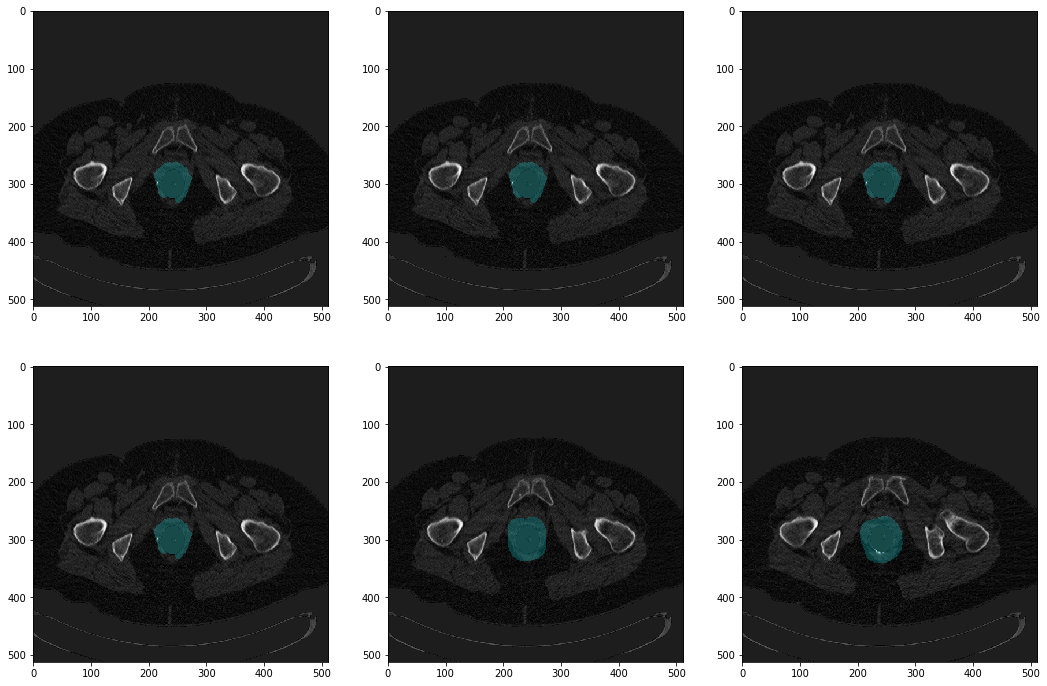

In [10]:
n_slices_skip = 4
display_slices(image, mask, rows=2, cols=3, skip = n_slices_skip)

# Read RT dose grids and resample them to have the same spatial resolution as CT images

In [11]:
RTD_name=[]
for f in filenames:
    if re.match('RTD_', f):
        RTD_name=f

reader = sitk.ImageFileReader()
reader.SetFileName(os.path.join(foldernames,RTD_name))
img = reader.Execute()

ds = dicom.read_file(os.path.join(foldernames,RTD_name))

if ds[0x30040002].value=='GY':
    img_array=sitk.GetArrayFromImage(img)
    img_array=img_array*ds[0x3004000E].value*100
if ds[0x30040002].value=='cGY':
    img_array=sitk.GetArrayFromImage(img)
    img_array=img_array*ds[0x3004000E].value
    
img1=sitk.GetImageFromArray(img_array)
img1.SetSpacing(img.GetSpacing())
img1.SetOrigin(img.GetOrigin())
img1.SetDirection(img.GetDirection())
identity = sitk.Transform(3, sitk.sitkIdentity)

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(image3D)
resampler.SetInterpolator(sitk.sitkBSpline)
resampler.SetSize(image3D.GetSize())
resampler.SetOutputOrigin(image3D.GetOrigin())
resampler.SetOutputDirection(image3D.GetDirection())
resampler.SetOutputSpacing(image3D.GetSpacing())
resampler.SetTransform(identity)
dosemap = resampler.Execute(img1)

# Visualisation of dose map within ROI

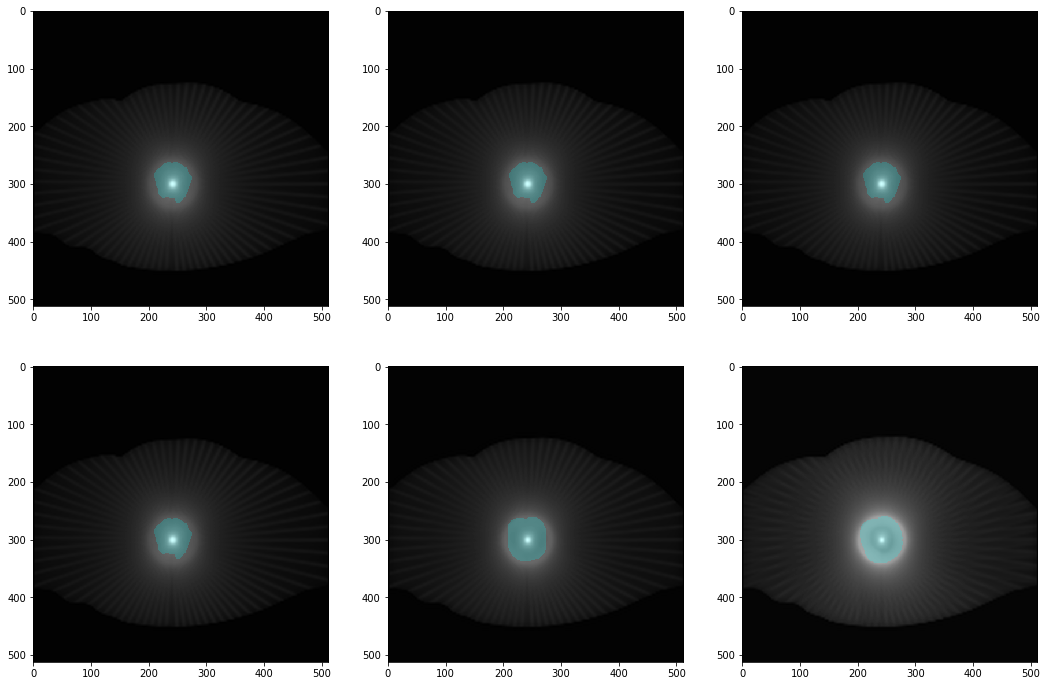

In [12]:
Dosemap = sitk.GetArrayFromImage(dosemap)
display_slices(Dosemap, mask, skip = n_slices_skip)

# Initialize feature extraction with defined parameters

In [13]:
gtv_mask=sitk.GetImageFromArray(sitk.GetArrayFromImage(gtv_mask))
gtv_mask.SetSpacing(spacing)
gtv_mask.SetOrigin(origin)
gtv_mask.SetDirection(direction)

image3D=sitk.Cast(image3D, sitk.sitkInt16)
gtv_mask=sitk.Cast(gtv_mask, sitk.sitkUInt8)
patient_name=os.path.basename(ptdir[0])

settings = {}
settings['binWidth'] = 25
settings['preCrop'] = True
settings['padDistance'] = 10 # Set pad distance when cropping images

extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
print('Extraction parameters:\n\t', extractor.settings)

extractor.disableAllImageTypes()
extractor.enableImageTypeByName('Original')
extractor.enableAllFeatures()

print('Calculating features')

outputFilepath = filepath # Set you own output path to save radiomics/dosiomics features.

Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': True, 'padDistance': 10, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 25}
Calculating features


# Extract features and save the results

In [14]:
featureVector = extractor.execute(image3D, gtv_mask)
result_R = pd.DataFrame(pd.Series(featureVector)).T
result_R.to_csv(outputFilepath + '/' + patient_name + '_radiomics.csv', index=False, na_rep='NaN')

RTstructure='rectal_gtv'

bb, correctedMask = imageoperations.checkMask(image3D, gtv_mask)
if correctedMask is not None:
    gtv_mask = correctedMask
image, mask = imageoperations.cropToTumorMask(image3D, gtv_mask, bb, padDistance=10)


outputFilepath_D = filepath # Set you own output path to save radiomics/dosiomics features.

featureVector = extractor.execute(dosemap, gtv_mask)
result_D = pd.DataFrame(pd.Series(featureVector)).T
result_D.to_csv(outputFilepath_D + '/' + patient_name + '_dosiomics.csv', index=False, na_rep='NaN')


parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
parameter force2D must be set to True to enable shape2D extraction
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


# View the extracted radiomics features

In [15]:
for key, value in six.iteritems(result_R):
    print('\t', key, ':', value)

	 diagnostics_Versions_PyRadiomics : 0    v3.0.1
Name: diagnostics_Versions_PyRadiomics, dtype: object
	 diagnostics_Versions_Numpy : 0    1.22.4
Name: diagnostics_Versions_Numpy, dtype: object
	 diagnostics_Versions_SimpleITK : 0    2.2.0
Name: diagnostics_Versions_SimpleITK, dtype: object
	 diagnostics_Versions_PyWavelet : 0    1.1.1
Name: diagnostics_Versions_PyWavelet, dtype: object
	 diagnostics_Versions_Python : 0    3.8.5
Name: diagnostics_Versions_Python, dtype: object
	 diagnostics_Configuration_Settings : 0    {'minimumROIDimensions': 2, 'minimumROISize': ...
Name: diagnostics_Configuration_Settings, dtype: object
	 diagnostics_Configuration_EnabledImageTypes : 0    {'Original': {}}
Name: diagnostics_Configuration_EnabledImageTypes, dtype: object
	 diagnostics_Image-original_Hash : 0    caa40a11bf3a4b4f19ee2c6f9a02dc14fda1b9fa
Name: diagnostics_Image-original_Hash, dtype: object
	 diagnostics_Image-original_Dimensionality : 0    3D
Name: diagnostics_Image-original_Dimensional

# View the extracted dosiomics features

In [16]:

for key, value in six.iteritems(result_D):
    print('\t', key, ':', value)

	 diagnostics_Versions_PyRadiomics : 0    v3.0.1
Name: diagnostics_Versions_PyRadiomics, dtype: object
	 diagnostics_Versions_Numpy : 0    1.22.4
Name: diagnostics_Versions_Numpy, dtype: object
	 diagnostics_Versions_SimpleITK : 0    2.2.0
Name: diagnostics_Versions_SimpleITK, dtype: object
	 diagnostics_Versions_PyWavelet : 0    1.1.1
Name: diagnostics_Versions_PyWavelet, dtype: object
	 diagnostics_Versions_Python : 0    3.8.5
Name: diagnostics_Versions_Python, dtype: object
	 diagnostics_Configuration_Settings : 0    {'minimumROIDimensions': 2, 'minimumROISize': ...
Name: diagnostics_Configuration_Settings, dtype: object
	 diagnostics_Configuration_EnabledImageTypes : 0    {'Original': {}}
Name: diagnostics_Configuration_EnabledImageTypes, dtype: object
	 diagnostics_Image-original_Hash : 0    3c71afe83f8a929f96f1dc902e238952812c99fe
Name: diagnostics_Image-original_Hash, dtype: object
	 diagnostics_Image-original_Dimensionality : 0    3D
Name: diagnostics_Image-original_Dimensional